### 1. Import Library dan Modul
Sebelum melanjutkan proses eksplorasi data dan visualisasi, beberapa pustaka penting perlu diimpor. Berikut ini penjelasan masing-masing:

os: Digunakan untuk operasi sistem file seperti memeriksa keberadaan folder, membaca file/direktori, dan menggabungkan path antar folder/file.

matplotlib.pyplot:
Pustaka visualisasi dasar di Python. Digunakan untuk menampilkan grafik, seperti histogram atau bar chart.

seaborn:
Library berbasis matplotlib yang menawarkan visualisasi statistik lebih informatif dan bergaya. Umumnya digunakan untuk membuat grafik distribusi dan heatmap.

pandas:
Digunakan untuk manipulasi dan analisis data tabular. Sangat berguna dalam membuat dan memanipulasi DataFrame, termasuk untuk menyiapkan data sebelum visualisasi.

numpy:
Pustaka untuk komputasi numerik. Sangat berguna untuk menghitung statistik seperti rata-rata, min, max, dan lain-lain.

cv2 (OpenCV):
Digunakan untuk membaca dan memproses gambar. Dalam konteks ini, digunakan untuk menampilkan beberapa contoh gambar dari dataset.

PIL.Image:
Digunakan untuk membuka gambar dan mendapatkan ukuran resolusinya (lebar dan tinggi). Alternatif ringan dari OpenCV untuk tugas pembacaan gambar sederhana.

Dengan semua pustaka ini, pipeline eksplorasi data dapat berjalan dengan lengkap mulai dari validasi data, analisis distribusi, hingga visualisasi dan penampilan contoh gambar secara sistematis.

In [11]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
from PIL import Image

### 2. Validasi Dataset
Fungsi ini bertugas untuk memastikan bahwa direktori dataset yang diberikan valid, yaitu benar-benar ada di sistem dan berisi subdirektori yang mewakili label atau kelas gambar. Jika direktori tidak ditemukan atau tidak ada subdirektori label, maka fungsi akan menampilkan error yang informatif. Ini merupakan langkah awal penting sebelum analisis lebih lanjut agar proses EDA tidak gagal karena struktur folder yang tidak sesuai.

In [40]:
def validate_dataset_dir(dataset_dir):
    """
    Fungsi melakukan iterasi terhadap isi folder dataset_dir, lalu mengambil hanya subdirektori (kelas) dan menyusunnya secara alfabetis ke dalam list labels. 
    Subdirektori ini merepresentasikan label dari dataset.
    """
    if not os.path.exists(dataset_dir):
        raise FileNotFoundError(f"❌ Dataset directory '{dataset_dir}' does not exist.")
    
    labels = sorted([
        d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))
    ])
    
    if not labels:
        raise ValueError(f"❌ No label folders found in '{dataset_dir}'")
    
    return labels

### 3. Menghitung Gambar Setiap Kelas
Fungsi ini menghitung jumlah gambar pada setiap kelas (subdirektori). Ia melakukan iterasi ke seluruh label yang tersedia, kemudian menghitung file yang ada dalam tiap folder label tersebut. Hasilnya berupa dictionary yang menyimpan nama kelas sebagai kunci dan jumlah gambar sebagai nilai. Fungsi ini juga dilengkapi dengan penanganan error jika folder gagal diakses, menjadikannya lebih tahan terhadap struktur data yang tidak konsisten.

In [ ]:
def count_images_per_class(dataset_dir, labels):
    """
    Kode ini menghitung jumlah file dalam setiap subfolder label dengan membuat folder_path dari dataset_dir dan label, 
    lalu menggunakan list comprehension untuk memeriksa apakah setiap item di dalam folder adalah file. 
    Semua file yang valid dihitung dengan len() dan hasilnya disimpan sebagai jumlah gambar per kelas.
    """
    data_counts = {}
    for label in labels:
        folder_path = os.path.join(dataset_dir, label)
        try:
            count = len([
                f for f in os.listdir(folder_path) 
                if os.path.isfile(os.path.join(folder_path, f))
            ])
            data_counts[label] = count
        except Exception as e:
            print(f"⚠️ Error accessing folder '{label}': {e}")
            data_counts[label] = 0
    return data_counts

### 4. Distribusi Gambar per Kelas
Fungsi ini mengambil hasil dari perhitungan jumlah gambar per kelas dan memvisualisasikannya dalam bentuk grafik batang. Selain menyajikan jumlah gambar, fungsi ini juga menghitung proporsi setiap kelas terhadap total dataset. Output visualisasi dapat disimpan ke file jika path diberikan, yang sangat berguna untuk dokumentasi laporan atau audit dataset.

In [ ]:
def plot_class_distribution(data_counts, save_path=None):
    """
    Pertama, kode membuat DataFrame df_counts dari dictionary data_counts yang berisi label dan jumlah gambar per kelas. 
    Kolom tambahan 'Proporsi' dihitung sebagai persentase jumlah gambar terhadap total keseluruhan. 
    Kemudian, visualisasi distribusi dilakukan dengan seaborn barplot yang menampilkan jumlah gambar per kelas secara visual, 
    menggunakan palet warna 'viridis', diurutkan dari yang terbanyak, dan tanpa legenda.
    """
    df_counts = pd.DataFrame(list(data_counts.items()), columns=['Label', 'Jumlah'])
    df_counts['Proporsi'] = df_counts['Jumlah'] / df_counts['Jumlah'].sum()

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_counts.sort_values(by='Jumlah', ascending=False),
        x='Label',
        y='Jumlah',
        hue='Label',
        palette='viridis',
        legend=False
    )
    plt.title('Distribusi Jumlah Gambar per Kelas')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.xticks(rotation=45)
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    plt.show()
    return df_counts

### 5. Menampilkan Gambar Sampel
Fungsi ini menampilkan contoh gambar dari setiap kelas untuk kebutuhan verifikasi visual. Ia menampilkan sejumlah n_per_class gambar dari tiap label secara grid. Ini berguna untuk memastikan bahwa gambar yang dimiliki memang relevan dan terlihat normal (tidak rusak, salah format, atau kosong). Penanganan error ditambahkan agar jika ada gambar rusak atau tidak bisa ditampilkan, proses tetap berlanjut tanpa terhenti.

In [ ]:
def show_sample_images(dataset_dir, labels, n_per_class=3, save_path=None):
    """
    Kode ini digunakan untuk menampilkan beberapa contoh gambar dari setiap kelas. 
    Ukuran grid subplot ditentukan berdasarkan jumlah kelas dan jumlah gambar per kelas (n_per_class). 
    Gambar-gambar diambil dari masing-masing folder kelas, difilter hanya file gambar, lalu dibaca menggunakan OpenCV dan dikonversi ke format warna RGB. 
    Gambar tersebut kemudian ditampilkan dalam grid menggunakan Matplotlib, dengan setiap subplot mewakili satu gambar tanpa menampilkan sumbu.
    """
    fig, axes = plt.subplots(len(labels), n_per_class, figsize=(n_per_class * 3, len(labels) * 2.5))
    for i, label in enumerate(labels):
        class_dir = os.path.join(dataset_dir, label)
        try:
            images = [
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f))
            ][:n_per_class]
        except Exception as e:
            print(f"⚠️ Failed to read images from '{label}': {e}")
            continue

        for j in range(n_per_class):
            try:
                img_path = os.path.join(class_dir, images[j])
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                if j == 0:
                    axes[i, j].set_ylabel(label, fontsize=12)
            except Exception as e:
                print(f"⚠️ Failed to display image '{images[j]}' in '{label}': {e}")
                axes[i, j].axis('off')
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    plt.show()

### 6. Analisis Ukuran Resolusi Gambar
Fungsi ini digunakan untuk menganalisis ukuran resolusi gambar (lebar dan tinggi) di seluruh dataset. Informasi seperti rata-rata, ukuran minimum, dan maksimum dari lebar dan tinggi akan dicetak ke layar, serta divisualisasikan dalam histogram distribusi. Ini penting untuk memahami seberapa konsisten ukuran gambar dan menentukan apakah diperlukan normalisasi ukuran sebelum pelatihan model.

In [ ]:
def analyze_image_sizes(dataset_dir, labels, save_path=None):
    """
    Bagian ini digunakan untuk mengevaluasi ukuran (resolusi) semua gambar dalam dataset. 
    Setiap gambar dibuka menggunakan PIL.Image untuk mengambil dimensi (lebar dan tinggi), lalu nilai-nilainya dikumpulkan ke dalam list widths dan heights.
    Setelah itu, statistik deskriptif seperti rata-rata, minimum, dan maksimum dari dimensi tersebut dihitung menggunakan NumPy.
    Terakhir, distribusi ukuran gambar divisualisasikan menggunakan Seaborn dan Matplotlib, sehingga kita bisa memahami konsistensi atau variasi resolusi dalam dataset.
    """
    widths, heights = [], []

    for label in labels:
        folder_path = os.path.join(dataset_dir, label)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            try:
                with Image.open(file_path) as img:
                    widths.append(img.width)
                    heights.append(img.height)
            except Exception as e:
                print(f"⚠️ Failed to open '{file_path}': {e}")

    print("\n📊 Statistik Ukuran Gambar:")
    print(f" - Rata-rata: {np.mean(widths):.1f} x {np.mean(heights):.1f}")
    print(f" - Minimum : {np.min(widths)} x {np.min(heights)}")
    print(f" - Maksimum: {np.max(widths)} x {np.max(heights)}")

    # Visualisasi distribusi
    plt.figure(figsize=(10, 5))
    sns.histplot(widths, color='skyblue', label='Width', kde=True)
    sns.histplot(heights, color='salmon', label='Height', kde=True)
    plt.legend()
    plt.title('Distribusi Ukuran Gambar (Width & Height)')
    plt.xlabel('Pixels')
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    plt.show()

### 7. Skrip Utama
Bagian utama dari skrip ini menjalankan pipeline eksplorasi data (EDA) untuk dataset klasifikasi sampah ketika file dijalankan secara langsung. Proses dimulai dengan mendefinisikan direktori dataset dan direktori output untuk menyimpan hasil visualisasi. Selanjutnya, dilakukan validasi struktur dataset dan ekstraksi label berdasarkan nama-nama folder yang merepresentasikan kelas. Setelah label berhasil didapatkan, sistem menghitung jumlah gambar per kelas untuk mengetahui distribusi data. Hasil perhitungan ini kemudian divisualisasikan dalam bentuk grafik distribusi dan disimpan ke dalam file output. Untuk memberikan gambaran visual dari isi dataset, sistem juga menampilkan beberapa contoh gambar dari masing-masing kelas. Terakhir, dilakukan analisis ukuran (resolusi) gambar di seluruh dataset, termasuk perhitungan statistik seperti rata-rata, minimum, dan maksimum ukuran, serta visualisasi distribusi dimensi gambar. Seluruh tahapan ini bertujuan untuk memberikan pemahaman mendalam terhadap karakteristik dataset sebelum digunakan dalam proses pelatihan model.

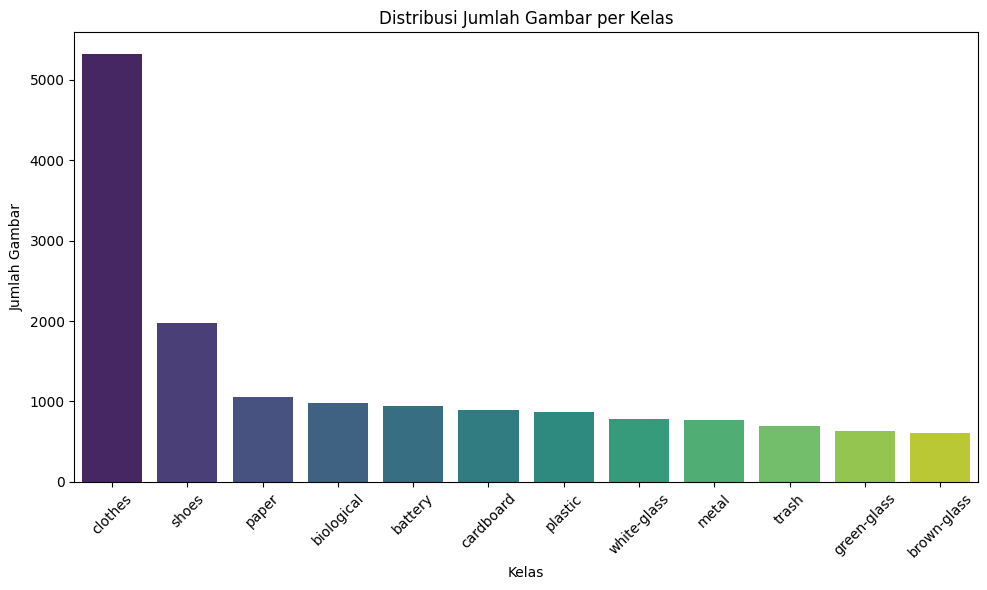

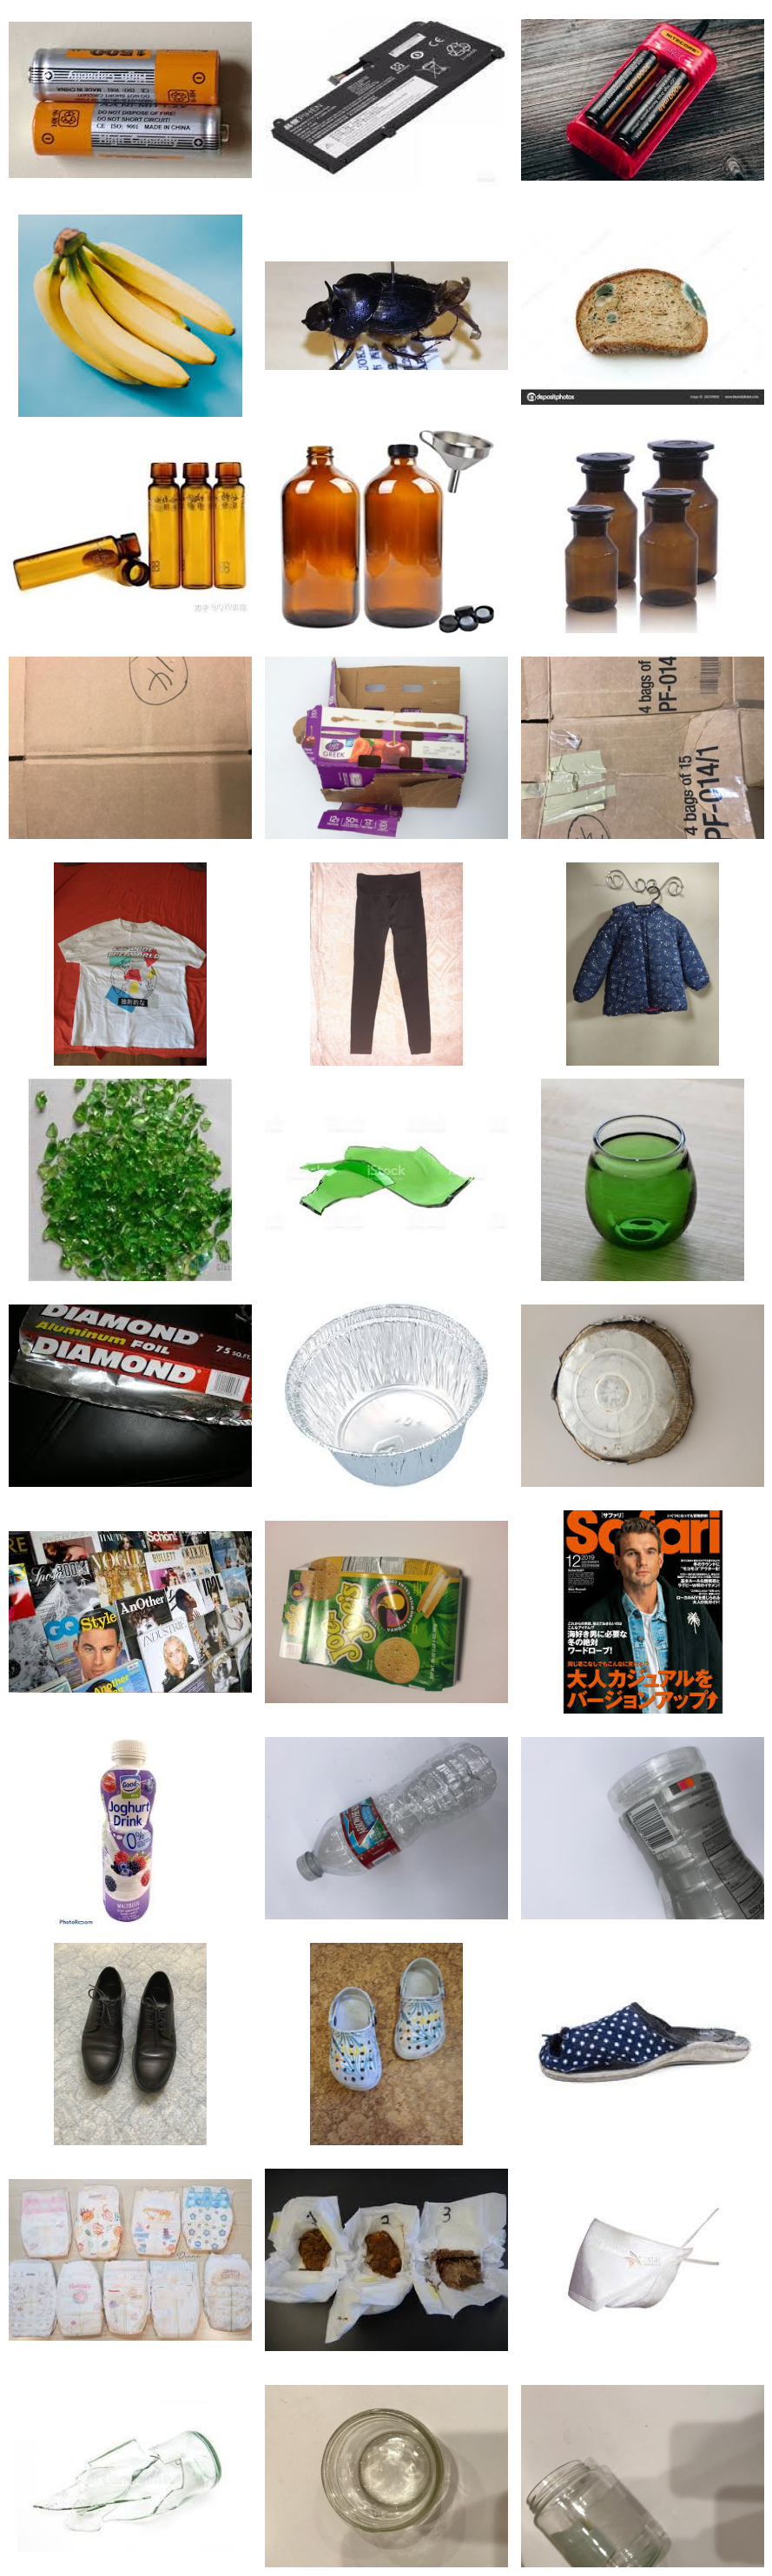


📊 Statistik Ukuran Gambar:
 - Rata-rata: 349.8 x 351.7
 - Minimum : 51 x 100
 - Maksimum: 888 x 936


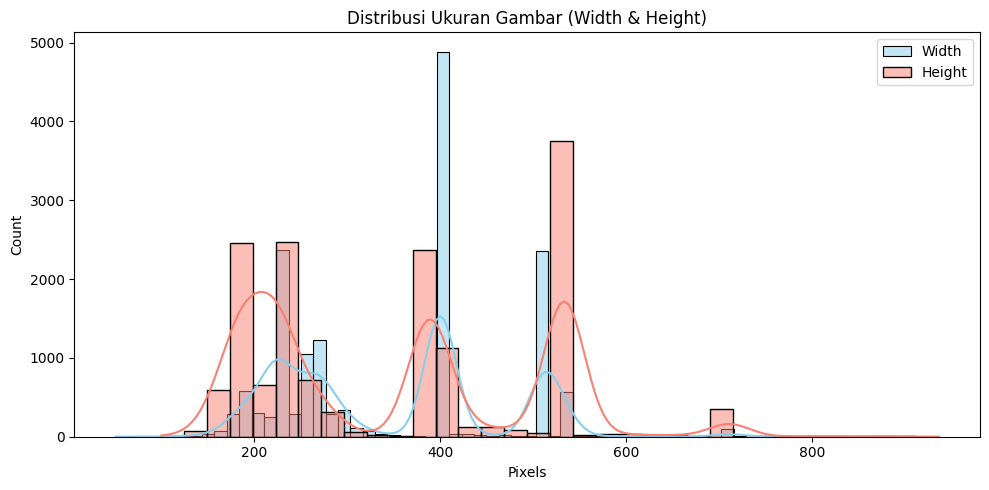

In [13]:
if __name__ == "__main__":
    DATASET_DIR = '../data/raw/garbage_dataset'
    OUTPUT_DIR = '../eda_outputs'

    # 1. Validasi dataset dan ambil label
    labels = validate_dataset(DATASET_DIR)

    # 2. Hitung jumlah gambar per kelas
    counts = count_images_per_class(DATASET_DIR, labels)

    # 3. Visualisasi distribusi kelas
    df_counts = plot_class_distribution(counts, save_path=f'{OUTPUT_DIR}/distribusi_kelas.png')

    # 4. Tampilkan contoh gambar
    show_sample_images(DATASET_DIR, labels, n_per_class=3, save_path=f'{OUTPUT_DIR}/contoh_gambar.png')

    # 5. Analisis ukuran gambar
    analyze_image_sizes(DATASET_DIR, labels, save_path=f'{OUTPUT_DIR}/distribusi_ukuran_gambar.png')